In [2]:
import h5py
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import numpy as np
from math import pi, cos, sin
from scipy.integrate import quad
from sklearn.manifold import TSNE

In [4]:
f = h5py.File('./MNIST data/train_0.h5', 'r')
data = f['data']
label = f['label']

In [6]:
# parameters
numOfClass = 10
numOfImagesEachClass = 100
numOfGaussian = 50
etaW = 1e-3
etaC = 1e-2
epsilon = 1

In [7]:
# data cleaning: choose images from each of the classes
selectedData, selectedLabel = ImageChoosing(numOfImagesEachClass, numOfClass)
selectedData = selectedData[:, :, 0:2]
#selectedData = selectedData[:, :, 0:3]

# putting 1000 images together
finalData = np.zeros((256 * numOfImagesEachClass * numOfClass, 2))
finalData = selectedData.reshape((256 * numOfImagesEachClass * numOfClass, 2))

In [24]:
# initializing C
gmm = GaussianMixture(n_components = numOfGaussian)
gmm.fit(finalData)
means = gmm.means_
covariances = gmm.covariances_
C = covariances
C = torch.from_numpy(C)
C.requires_grad_(True)
C = NormalizingC(C)
print(C)

tensor([[[  5.0000e-01,  -4.0454e-32],
         [ -4.1283e-32,   5.0000e-01]],

        [[  5.2585e-01,   1.4901e-08],
         [  1.4901e-08,   4.7415e-01]],

        [[  5.4017e-01,  -2.3739e-08],
         [ -2.3739e-08,   4.5983e-01]],

        [[  6.4818e-01,  -2.8214e-07],
         [ -2.8214e-07,   3.5182e-01]],

        [[  5.0000e-01,   2.4198e-34],
         [  2.4198e-34,   5.0000e-01]],

        [[  5.0000e-01,  -7.2208e-35],
         [ -7.2208e-35,   5.0000e-01]],

        [[  5.0711e-01,   1.6008e-08],
         [  1.6008e-08,   4.9289e-01]],

        [[  6.3440e-01,  -1.0544e-07],
         [ -1.0544e-07,   3.6560e-01]],

        [[  5.0000e-01,   1.7743e-34],
         [  2.2179e-34,   5.0000e-01]],

        [[  5.9856e-01,   1.0691e-09],
         [  1.0691e-09,   4.0144e-01]],

        [[  5.0672e-01,  -1.3402e-08],
         [ -1.3402e-08,   4.9328e-01]],

        [[  5.0000e-01,  -2.9510e-34],
         [ -2.9510e-34,   5.0000e-01]],

        [[  6.4584e-01,   1.8394e-07],
 

In [29]:
# initializing W
W = np.random.random_sample((numOfClass * numOfImagesEachClass, numOfGaussian))

# normalizing W
W = torch.from_numpy(W)
temp = NormalizingW(W)
W = temp
W.requires_grad_(True)
W.retain_grad()
print(W)

tensor([[0.0169, 0.0124, 0.0223,  ..., 0.0191, 0.0368, 0.0131],
        [0.0395, 0.0445, 0.0103,  ..., 0.0058, 0.0373, 0.0253],
        [0.0114, 0.0238, 0.0405,  ..., 0.0233, 0.0232, 0.0302],
        ...,
        [0.0167, 0.0212, 0.0011,  ..., 0.0267, 0.0036, 0.0356],
        [0.0410, 0.0216, 0.0358,  ..., 0.0286, 0.0270, 0.0277],
        [0.0342, 0.0343, 0.0416,  ..., 0.0423, 0.0221, 0.0399]],
       dtype=torch.float64, requires_grad=True)


No handles with labels found to put in legend.


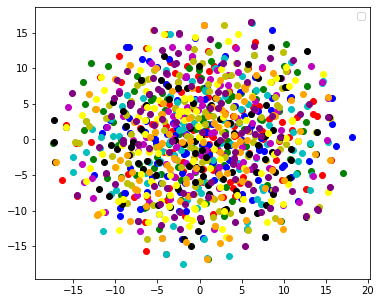

In [10]:
# graph
graphW = np.random.random_sample((numOfClass * numOfImagesEachClass, numOfGaussian))
for i in range(graphW.shape[0]):
    for j in range(graphW.shape[1]):
        graphW[i][j] = W[i][j]
tsne = TSNE(n_components=2, random_state=0)
W_2d = tsne.fit_transform(graphW)
target_ids = range(numOfClass * numOfImagesEachClass)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
label = selectedLabel.astype(int)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple']
for i in range(numOfClass * numOfImagesEachClass):
    plt.scatter(W_2d[i,0], W_2d[i,1], color = colors[label[i]])
plt.legend()
plt.show()

In [30]:
# initializing flag
flag = 1

# compute X
X = GenerateX()
X = torch.from_numpy(X)

# compute Xhat
Xhat = GenerateXhat()

In [31]:
# compute objective function E
E = GenerateE()
E.requires_grad_(True)

tensor(425.3047, dtype=torch.float64, grad_fn=<AddBackward0>)

In [1]:
# begin gradient descent
lambda_ = 0
YCNew = C
YW = torch.sqrt(W)
YWNew = W

while True:
    print("Error of iteration", flag, "is:", E.item())
    EOld = E
    lambdaNew_ = (1 + np.sqrt(1 + 4 * np.power(lambda_, 2))) / 2
    gama = (1 - lambda_) / lambdaNew_
    lambda_ = lambdaNew_
    WGrad = torch.autograd.grad(E, W, create_graph = True, allow_unused = True)[0]
    CGrad = torch.autograd.grad(E, C, create_graph = True, allow_unused = True)[0]
    CGrad = NormalizingCGrad(CGrad)
    WGrad = NormalizingWGrad(WGrad)
    YWNew = YW - torch.mul(WGrad, etaW)
    YWNew = (1 - gama) * YWNew + gama * YW
    YW = YWNew
    W = torch.pow(YWNew, 2)
    W = NormalizingW(W)
    for j in range(numOfGaussian):
        YCNew[j] = ExponentialMap(C[j], - etaC * CGrad[j])
        C[j] = ExponentialMap(YCNew[j], gama * LogMap(YCNew[j], C[j]))
    Xhat = GenerateXhat()
    E = GenerateE()
    if flag == 50:
        print("The Final Error is:", E.item())
        break
    flag += 1

NameError: name 'C' is not defined

No handles with labels found to put in legend.


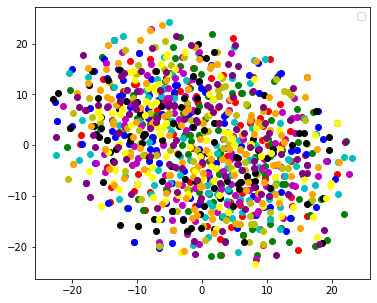

In [54]:
# graph tsne
graphW = np.random.random_sample((numOfClass * numOfImagesEachClass, numOfGaussian))
for i in range(graphW.shape[0]):
    for j in range(graphW.shape[1]):
        graphW[i][j] = W[i][j]
tsne = TSNE(n_components=2, random_state=0)
W_2d = tsne.fit_transform(graphW)
target_ids = range(numOfClass * numOfImagesEachClass)

plt.figure(figsize=(6, 5))
label = selectedLabel.astype(int)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple']
for i in range(numOfClass * numOfImagesEachClass):
    plt.scatter(W_2d[i,0], W_2d[i,1], color = colors[label[i]])
plt.legend()
plt.savefig('tsne.png')
plt.show()


No handles with labels found to put in legend.


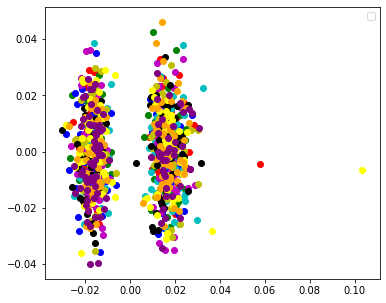

In [51]:
from sklearn.decomposition import PCA

data = graphW
pca = PCA(n_components=3, svd_solver='full')
result = pca.fit_transform(data)
plt.figure(figsize=(6, 5))
label = selectedLabel.astype(int)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'yellow', 'orange', 'purple']
for i in range(numOfClass * numOfImagesEachClass):
    plt.scatter(result[i,0], result[i,1], color = colors[label[i]])
plt.legend()
plt.show()

In [52]:
print(pca.explained_variance_ratio_)

[0.0456893  0.02822475 0.02789031]


In [24]:
count = 0
for i in range(1000):
    for j in range(50):
        if W[i][j] < 0.001:
            count += 1
print(count/(1000 * 50))

0.02686


In [23]:
# helper functions
def ImageChoosing(numEach, numOfClass):
    selectedData = np.zeros((numEach * numOfClass, 256, 4))
    selectedLabel = np.zeros(numEach * numOfClass)
    count = np.zeros(numOfClass, dtype = int)
    for i in range(label.size):
        thisData = data[i]
        thisLabel = label[i]
        thisCount = count[thisLabel]
        if thisCount < numEach:
            selectedData[thisLabel * numEach + thisCount] = data[i]
            selectedLabel[thisLabel * numEach + thisCount] = label[i]
            count[thisLabel] += 1
        else:
            exit = True
            for j in range(numOfClass):
                if count[j] < numEach:
                    exit = False
            if exit:
                break
    return selectedData, selectedLabel

def NormalizingW(W):
    result = W.clone()
    for i in range(W.shape[0]):
        sumOfW = torch.sum(W[i])
        for j in range(W.shape[1]):
            result[i][j] = W[i][j] / sumOfW
    return result

def GenerateX():
    result = np.zeros((numOfClass * numOfImagesEachClass, 2, 2))
    for i in range(numOfClass * numOfImagesEachClass):
        thisData = selectedData[i]
        gmm = GaussianMixture(n_components = 1)
        gmm.fit(thisData)
        means = gmm.means_
        covariances = gmm.covariances_
        result[i] = covariances
    return result

def GenerateXhat():
    result = np.zeros((numOfClass * numOfImagesEachClass, 2, 2))
    result = torch.from_numpy(result)
    for i in range(numOfClass * numOfImagesEachClass):
        A = 0
        B = 0
        for j in range(numOfGaussian):
            A += W[i][j] * C[j]
            B += W[i][j] * torch.inverse(C[j])
        firstTerm = sqrtMatrix(torch.inverse(B))
        secondTerm = sqrtMatrix(torch.mm(torch.mm(sqrtMatrix(B),A),sqrtMatrix(B)))
        thirdTerm = firstTerm
        result[i] = torch.mm(torch.mm(firstTerm, secondTerm), thirdTerm)
    return result

def sqrtMatrix(matrix):
    u, s, v = torch.svd(matrix)
    newS = torch.sqrt(torch.diag(s))
    return torch.mm(torch.mm(u, newS), v.t())
    
def GenerateE():
    E = 0
    for i in range(numOfClass * numOfImagesEachClass):
        #temp = torch.trace(torch.mm(torch.inverse(X[i]), Xhat[i]) + torch.mm(torch.inverse(Xhat[i]), X[i]))
        #E += (1 / 4) * (temp - 4)
        temp = torch.norm(X[i] - Xhat[i])
        E += temp
    return E

def ExponentialMap(x, V):
    u, s, v = torch.svd(V)
    temp = torch.exp(s)
    newS = torch.diag(temp)
    midTerm = torch.mm(torch.mm(u, newS), u.t())
    return torch.mm(torch.mm(sqrtMatrix(x), midTerm), sqrtMatrix(x))

def LogMap(x, Y):
    u, s, v = torch.svd(Y)
    newS = torch.diag(torch.log(s))
    midTerm = torch.mm(torch.mm(u, newS), u.t())
    return torch.mm(torch.mm(sqrtMatrix(x), midTerm), sqrtMatrix(x))
    
def NormalizingWGrad(grad):
    temp = grad.clone()
    for i in range(grad.shape[0]):
        sumOfGrad = torch.sum(grad[i])
        for j in range(grad.shape[1]):
            temp[i][j] = grad[i][j] / sumOfGrad
    return temp

def NormalizingCGrad(grad):
    temp = grad.clone()
    for i in range(grad.shape[0]):
        sumOfGrad = torch.sum(grad[i])
        for j in range(grad.shape[1]):
            for k in range(grad.shape[2]):
                temp[i][j][k] = grad[i][j][k] / sumOfGrad
    return temp

def NormalizingC(C):
    temp = C.clone()
    for i in range(C.shape[0]):
        sumOfC = torch.sum(torch.abs(C[i]))
        for j in range(C.shape[1]):
            for k in range(C.shape[2]):
                temp[i][j][k] = C[i][j][k] / sumOfC
    return temp

def CheckW(W):
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            if W[i][j] < 0:
                print("W has negative components on", i)

def CheckC(C):
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if C[i][j][j] < 0:
                print("C has negative components on the diag on the", j, "row of ", i, "element")

def CheckYCNew(C):
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if C[i][j][j] < 0:
                print("YCNew has negative components on the diag on the", j, "row of ", i, "element")